             Month  Sales_Saison  Revenu_Saison  Sales_Annuel  Revenu_Annuel  \
0     October 2024           0.0           0.00         223.0       15699.20   
1    November 2024           0.0           0.00         163.0       11475.20   
2    December 2024         950.0       18810.00         151.0       10630.40   
3     January 2025           0.0           0.00         132.0        9292.80   
4    February 2025           0.0           0.00         242.0       17036.80   
5       March 2025        1900.0       37620.00         297.0       20908.80   
6       April 2025           0.0           0.00         259.0       18233.60   
7         May 2025           0.0           0.00         118.0        8307.20   
8        June 2025        4750.0       94050.00         463.0       32595.20   
9        July 2025           0.0           0.00         234.0       16473.60   
10     August 2025           0.0           0.00         269.0       18937.60   
11  September 2025        9500.0      18

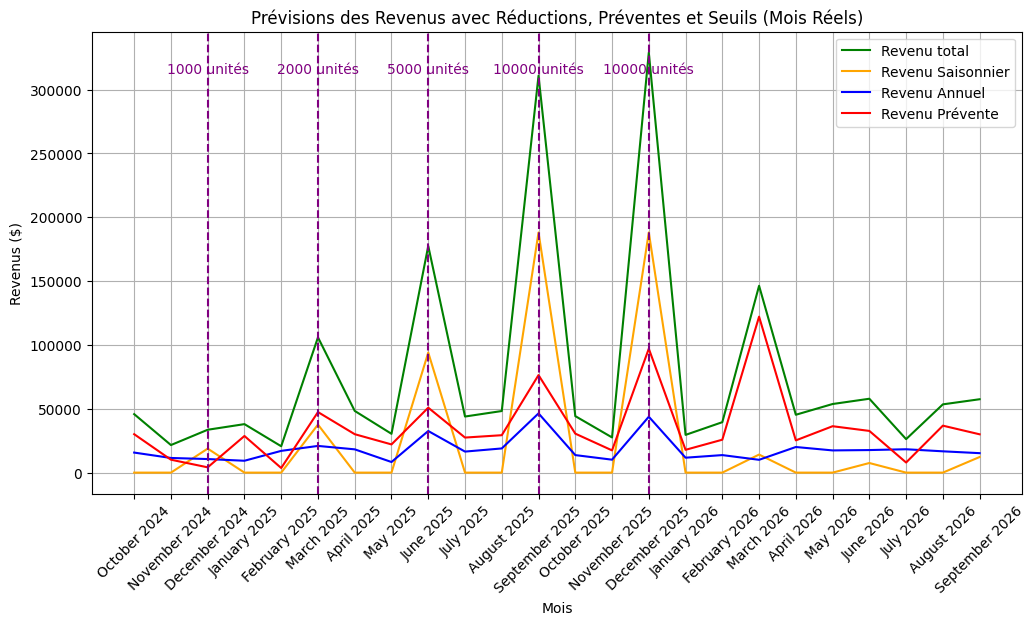

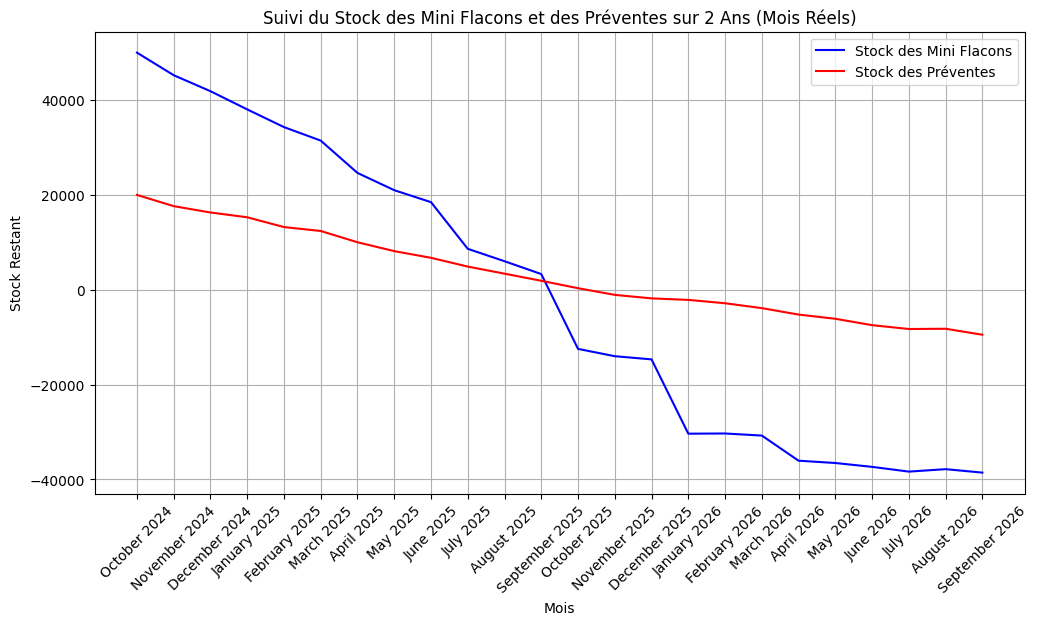

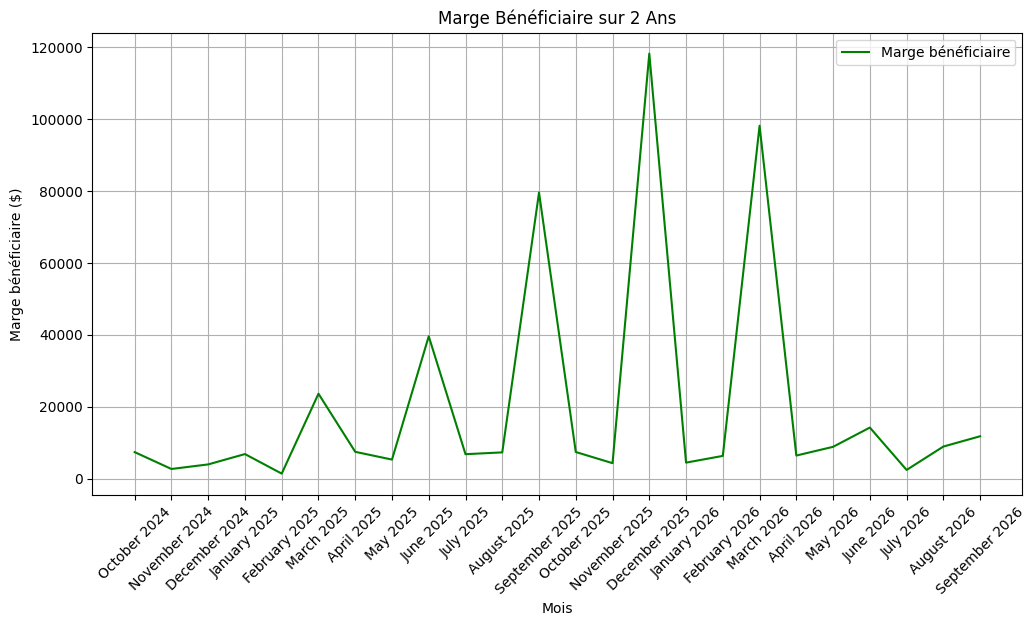

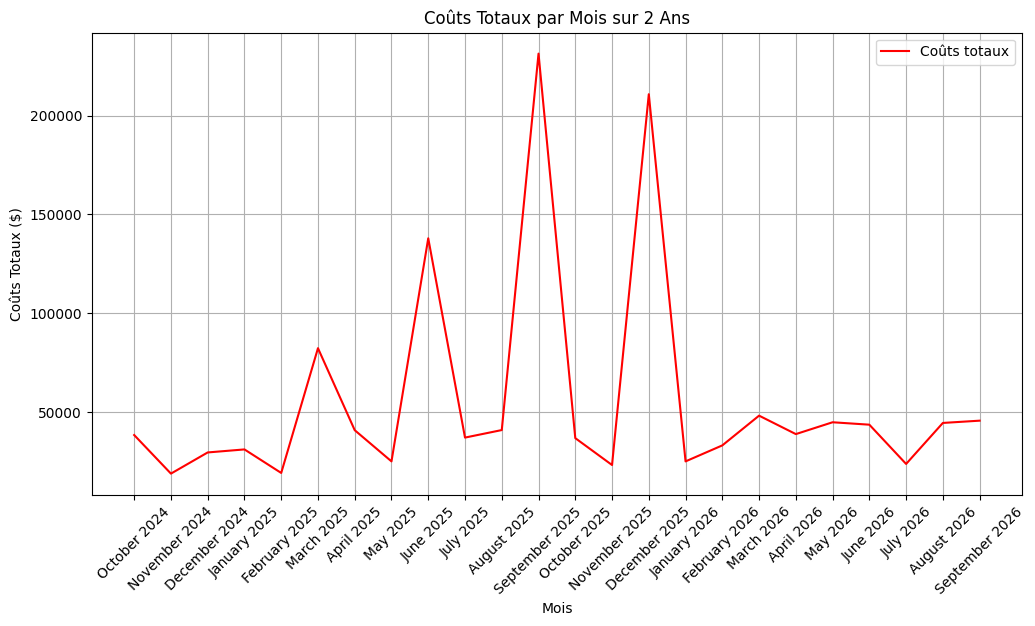

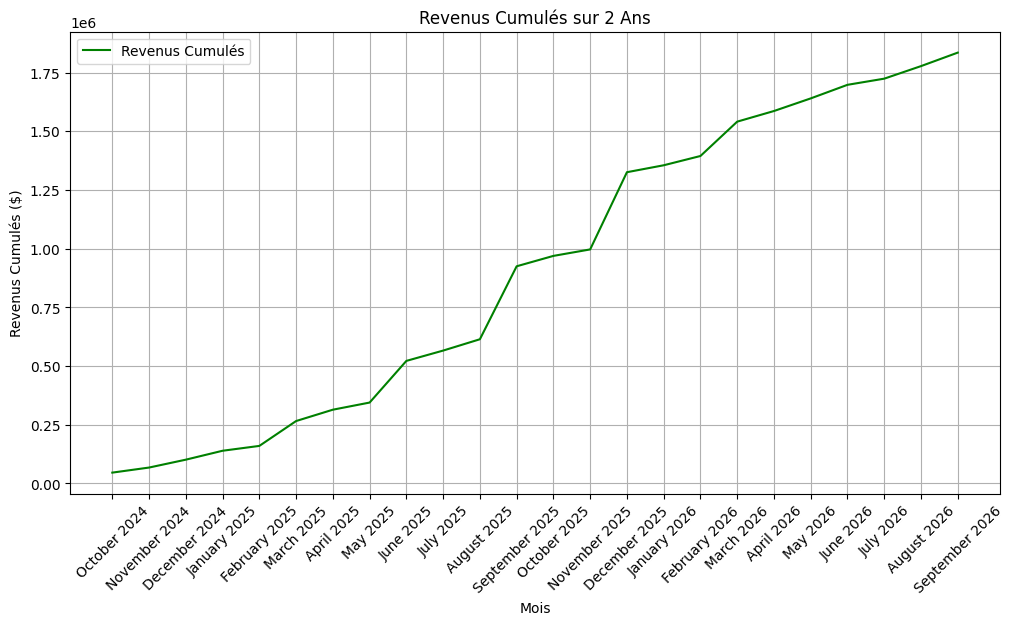

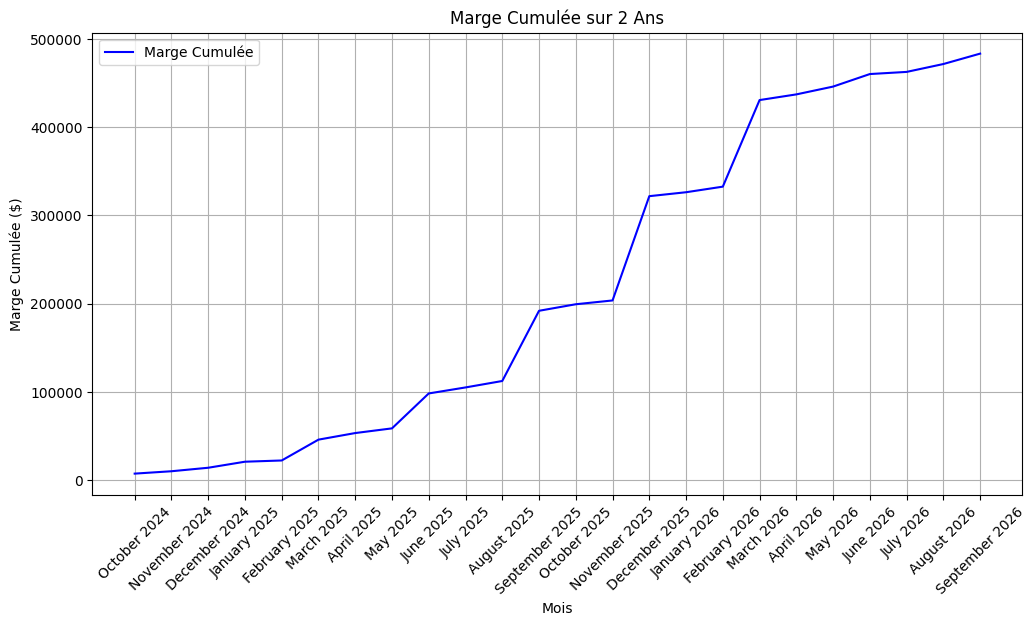

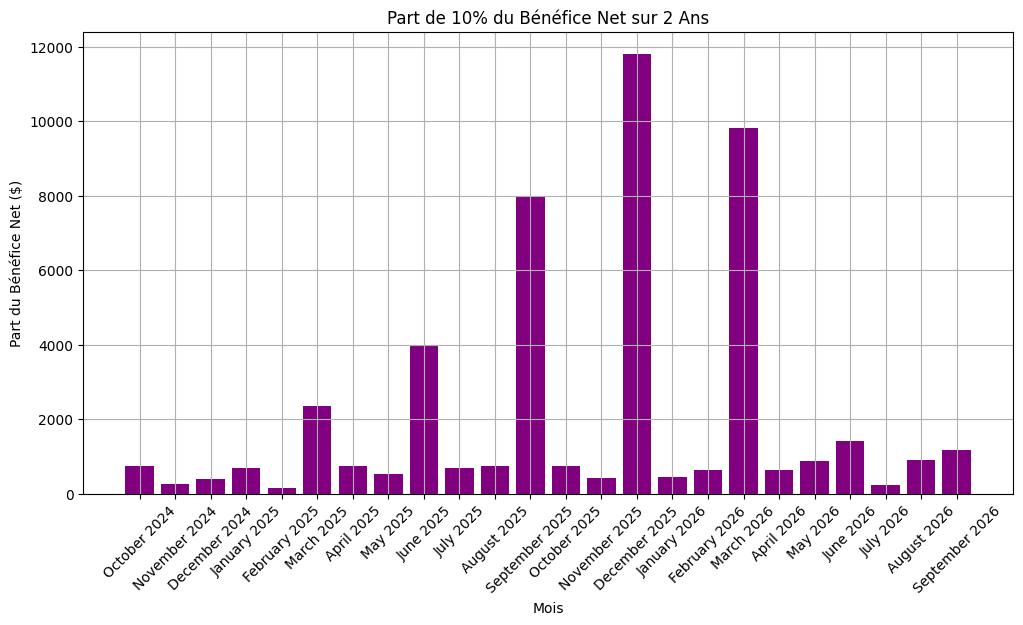

             Month  Profit_Margin  Net_Profit_Share
0     October 2024        7375.20           737.520
1    November 2024        2691.20           269.120
2    December 2024        3962.40           396.240
3     January 2025        6836.80           683.680
4    February 2025        1400.80           140.080
5       March 2025       23612.80          2361.280
6       April 2025        7461.60           746.160
7         May 2025        5303.20           530.320
8        June 2025       39571.20          3957.120
9        July 2025        6801.60           680.160
10     August 2025        7305.60           730.560
11  September 2025       79541.60          7954.160
12    October 2025        7408.00           740.800
13   November 2025        4305.60           430.560
14   December 2025      118152.80         11815.280
15    January 2026        4458.40           445.840
16   February 2026        6328.00           632.800
17      March 2026       98102.56          9810.256
18      Apri

In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime

# Paramètres
price_season = 25  # prix pour achat saisonnier
discount_season_renewal = 0.9  # réduction de 10% pour les renouvellements saisonniers
discount_annual = 0.8  # réduction de 20% pour l'achat annuel
price_surparfum = 88  # prix du surparfum en prévente
price_annual_prevent = 4 * price_season * discount_annual + price_surparfum  # prix total pour l'achat annuel + surparfum avec réduction
unit_goal_prevent = 20000  # objectif pour la prévente du surparfum
stock_initial_flacons = 50000  # stock initial des mini flacons
stock_initial_preventes = 20000  # stock initial des préventes
churn_rate = 0.05  # 5% de churn

# Coûts
cost_acquisition = 5  # coût d'acquisition par unité
cost_fabrication = 8  # coût de fabrication par unité
manufacturer_cut = 4  # coupe du fabricant par unité

# Paramètres supplémentaires
surparfum_rate = 0.10  # 10% des clients saisonniers achètent un surparfum 3 mois après
season_to_annual_conversion = 0.05  # 5% des clients saisonniers passent en annuel

# Début des ventes en octobre 2024
start_date = datetime(2024, 10, 1)
months = pd.date_range(start=start_date, periods=24, freq='MS').strftime("%B %Y")  # Mois réels

# Dates de seuils (mois dans la simulation)
seuils_ventes = {
    'December 2024': 1000,
    'March 2025': 2000,
    'June 2025': 5000,
    'September 2025': 10000,
    'December 2025': 10000
}

# Simulation continue des ventes saisonnières sur 8 saisons à partir d'octobre 2024
sales_season = np.zeros(24)
season_months = [2, 5, 8, 11]  # Mois des saisons (mars, juin, septembre, décembre dans l'index)
for year in range(2):  # 2 ans
    for month in season_months:
        sales_season[year * 12 + month] = float(np.random.randint(300, 800))  # Vente aléatoire pour chaque saison

# Appliquer les seuils spécifiques
for month_str, units in seuils_ventes.items():
    month_index = months.tolist().index(month_str)
    sales_season[month_index] = units

# Ventes annuelles et préventes (multipliées par 4 flacons)
sales_annual = np.array(np.random.randint(100, 300, size=24), dtype=float)  # simulation des ventes annuelles
sales_prevent = np.array(np.random.randint(0, 500, size=24), dtype=float)  # simulation des ventes de préventes

# Calcul des préventes de surparfum après 3 mois pour 10% des clients saisonniers
pre_surparfum = np.zeros(24, dtype=float)
for i in range(3, 24):  # Surparfum acheté 3 mois après les achats saisonniers
    pre_surparfum[i] = sales_season[i-3] * surparfum_rate

# Conversion de 5% des clients saisonniers en annuels
converted_to_annual = sales_season * season_to_annual_conversion
sales_annual += converted_to_annual  # Ajout des conversions aux ventes annuelles
sales_season -= converted_to_annual  # Retrait des conversions des ventes saisonnières

# Calcul des revenus avec réductions
revenues_season = sales_season * price_season * discount_season_renewal  # avec rabais de 10% pour les renouvellements
revenues_annual = sales_annual * 4 * price_season * discount_annual  # avec rabais de 20% pour les annuels
revenues_prevent = (sales_prevent + pre_surparfum) * price_surparfum  # inclut le surparfum avec réduction

# Total revenu par mois
total_revenue = revenues_season + revenues_annual + revenues_prevent

# Calcul des coûts totaux
total_units_sold = sales_season + 4 * (sales_annual + sales_prevent)
total_costs = total_units_sold * (cost_acquisition + cost_fabrication + manufacturer_cut)

# Calcul de la marge bénéficiaire après coûts
profit_margin = total_revenue - total_costs

# Suivi du stock
stock_flacons = np.full(24, stock_initial_flacons, dtype=float)  # Initialisation du stock pour chaque mois
stock_preventes = np.full(24, stock_initial_preventes, dtype=float)  # Stock initial des préventes

# Mise à jour du stock en fonction des ventes (ventes annuelles et préventes comptent pour 4 flacons, avec churn)
for i in range(1, 24):
    # Calcul des ventes totales : 4 flacons par vente annuelle et prévente, et on applique le churn
    total_sales = sales_season[i-1] + 4 * (sales_annual[i-1] + sales_prevent[i-1] + pre_surparfum[i-1])

    # Mise à jour du stock avec churn
    stock_flacons[i] = stock_flacons[i-1] * (1 - churn_rate) - total_sales
    stock_preventes[i] = stock_preventes[i-1] * (1 - churn_rate) - (4 * sales_prevent[i-1])

# Création d'un DataFrame pour tout afficher avec des dates réelles
df = pd.DataFrame({
    'Month': months,
    'Sales_Saison': sales_season,
    'Revenu_Saison': revenues_season,
    'Sales_Annuel': sales_annual,
    'Revenu_Annuel': revenues_annual,
    'Sales_Prevente': sales_prevent,
    'Revenu_Prevente': revenues_prevent,
    'Total_Revenu': total_revenue,
    'Total_Costs': total_costs,
    'Profit_Margin': profit_margin,
    'Stock_Flacons': stock_flacons,
    'Stock_Preventes': stock_preventes
})

# Affichage du DataFrame
print(df)

# Visualisation des résultats avec dates réelles
plt.figure(figsize=(12, 6))
plt.plot(df['Month'], df['Total_Revenu'], label="Revenu total", color='green')
plt.plot(df['Month'], df['Revenu_Saison'], label="Revenu Saisonnier", color='orange')
plt.plot(df['Month'], df['Revenu_Annuel'], label="Revenu Annuel", color='blue')
plt.plot(df['Month'], df['Revenu_Prevente'], label="Revenu Prévente", color='red')

# Indicateurs des seuils avec mois réels
for month_str, units in seuils_ventes.items():
    plt.axvline(x=month_str, color='purple', linestyle='--')
    plt.text(month_str, max(total_revenue) * 0.95, f"{units} unités", color='purple', fontsize=10, ha='center')

plt.title("Prévisions des Revenus avec Réductions, Préventes et Seuils (Mois Réels)")
plt.xlabel("Mois")
plt.xticks(rotation=45)
plt.ylabel("Revenus ($)")
plt.legend()
plt.grid(True)
plt.show()

# Visualisation du stock des flacons et des préventes avec dates réelles
plt.figure(figsize=(12, 6))
plt.plot(df['Month'], df['Stock_Flacons'], label="Stock des Mini Flacons", color='blue')
plt.plot(df['Month'], df['Stock_Preventes'], label="Stock des Préventes", color='red')

plt.title("Suivi du Stock des Mini Flacons et des Préventes sur 2 Ans (Mois Réels)")
plt.xlabel("Mois")
plt.xticks(rotation=45)
plt.ylabel("Stock Restant")
plt.legend()
plt.grid(True)
plt.show()

# Visualisation des marges bénéficiaires
plt.figure(figsize=(12, 6))
plt.plot(df['Month'], df['Profit_Margin'], label="Marge bénéficiaire", color='green')

plt.title("Marge Bénéficiaire sur 2 Ans")
plt.xlabel("Mois")
plt.xticks(rotation=45)
plt.ylabel("Marge bénéficiaire ($)")
plt.legend()
plt.grid(True)
plt.show()

# Visualisation des coûts
# Visualisation des coûts totaux par mois
plt.figure(figsize=(12, 6))
plt.plot(df['Month'], df['Total_Costs'], label="Coûts totaux", color='red')

plt.title("Coûts Totaux par Mois sur 2 Ans")
plt.xlabel("Mois")
plt.xticks(rotation=45)
plt.ylabel("Coûts Totaux ($)")
plt.legend()
plt.grid(True)
plt.show()

# Visualisation des revenus cumulés
plt.figure(figsize=(12, 6))
plt.plot(df['Month'], df['Total_Revenu'].cumsum(), label="Revenus Cumulés", color='green')

plt.title("Revenus Cumulés sur 2 Ans")
plt.xlabel("Mois")
plt.xticks(rotation=45)
plt.ylabel("Revenus Cumulés ($)")
plt.legend()
plt.grid(True)
plt.show()

# Visualisation des marges cumulées
plt.figure(figsize=(12, 6))
plt.plot(df['Month'], df['Profit_Margin'].cumsum(), label="Marge Cumulée", color='blue')

plt.title("Marge Cumulée sur 2 Ans")
plt.xlabel("Mois")
plt.xticks(rotation=45)
plt.ylabel("Marge Cumulée ($)")
plt.legend()
plt.grid(True)
plt.show()

# Calcul de la part de bénéfice net (10%)
net_profit_share = df['Profit_Margin'] * 0.10

# Ajout de la part dans le DataFrame
df['Net_Profit_Share'] = net_profit_share

# Visualisation de la part que tu prendras (10% du bénéfice net) sous forme de diagramme en bar
plt.figure(figsize=(12, 6))
plt.bar(df['Month'], df['Net_Profit_Share'], color='purple')

plt.title("Part de 10% du Bénéfice Net sur 2 Ans")
plt.xlabel("Mois")
plt.xticks(rotation=45)
plt.ylabel("Part du Bénéfice Net ($)")
plt.grid(True)
plt.show()

# Affichage du DataFrame mis à jour avec la part de bénéfice net
print(df[['Month', 'Profit_Margin', 'Net_Profit_Share']])
